In [1]:
from __future__ import division, print_function, unicode_literals

import numpy as np
import os

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

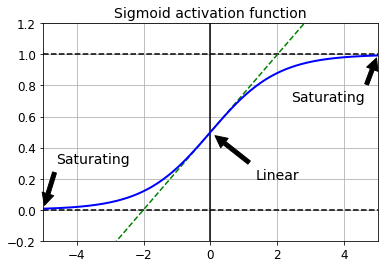

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5,5], [0,0], 'k--')
plt.plot([-5,5], [1,1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z , logit(z), "b-", linewidth=2)
props = dict(facecolor='black',shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops= props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,fontsize=14, ha="center")
plt.annotate('Linear',xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show()

In [4]:
import tensorflow as tf

In [5]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [6]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, kernel_initializer=he_init,name="hidden1")

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha * z, z)

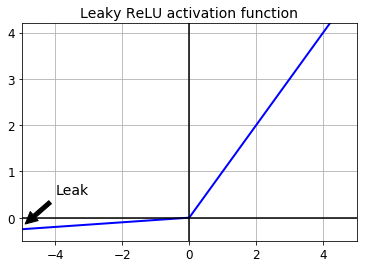

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0,0], 'k-')
plt.plot([0, 0], [-.5, 4.2],'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

In [9]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [10]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

In [11]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [12]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [13]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [14]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [15]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [16]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [17]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [18]:
(X_train, y_train),(X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28 * 28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28 * 28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [19]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [20]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y:y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y:y_valid})
            print(epoch,"Batch accuracy:", acc_batch,"Validation accuracy", acc_valid)
            
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy 0.9044
5 Batch accuracy: 0.94 Validation accuracy 0.9494
10 Batch accuracy: 0.92 Validation accuracy 0.9652
15 Batch accuracy: 0.94 Validation accuracy 0.971
20 Batch accuracy: 1.0 Validation accuracy 0.976
25 Batch accuracy: 1.0 Validation accuracy 0.9778
30 Batch accuracy: 0.98 Validation accuracy 0.978
35 Batch accuracy: 1.0 Validation accuracy 0.9786


In [21]:
def elu(z, alpha= 1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

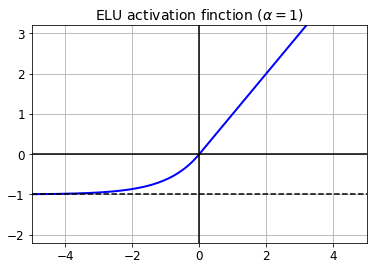

In [22]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1,-1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation finction ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [23]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [24]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

In [25]:
from scipy.special import erfc

alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc( 1/ np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))** 2 * np.e - 2*(2+np.pi)* erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [26]:
def selu(z, scale=scale_0_1,alpha=alpha_0_1):
    return scale * elu(z, alpha)

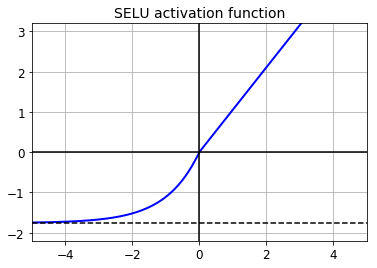

In [27]:
plt.plot(z, selu(z),"b-",linewidth=2)
plt.plot([-5, 5], [0, 0],'k-')
plt.plot([-5,5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function",fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [28]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(1000):
    W = np.random.normal(size=(100,100), scale=np.sqrt(1 / 100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean{:.2f}, std deviation {:.2f}".format(layer,means,stds))

Layer 0: mean-0.00, std deviation 1.00
Layer 100: mean0.02, std deviation 0.96
Layer 200: mean0.01, std deviation 0.90
Layer 300: mean-0.02, std deviation 0.92
Layer 400: mean0.05, std deviation 0.89
Layer 500: mean0.01, std deviation 0.93
Layer 600: mean0.02, std deviation 0.92
Layer 700: mean-0.02, std deviation 0.90
Layer 800: mean0.05, std deviation 0.83
Layer 900: mean0.02, std deviation 1.00


In [29]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
outputs = 10

X = tf.placeholder(tf.float32,shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1,activation=tf.nn.selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

In [30]:
means = X_train.mean(axis = 0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)
        
        
    save_path = saver.save(sess, "./my_model_selu.ckpt")

0 Batch accuracy: 0.92 Validation accuracy: 0.9194
5 Batch accuracy: 0.96 Validation accuracy: 0.9546
10 Batch accuracy: 0.98 Validation accuracy: 0.9638
15 Batch accuracy: 0.96 Validation accuracy: 0.9676
20 Batch accuracy: 1.0 Validation accuracy: 0.968
25 Batch accuracy: 1.0 Validation accuracy: 0.9684
30 Batch accuracy: 1.0 Validation accuracy: 0.9714
35 Batch accuracy: 1.0 Validation accuracy: 0.9716


In [31]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10 

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training, momentum=0.9)

In [32]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

In [33]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

In [34]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()
    
    my_batch_norm_layer = partial(
        tf.layers.batch_normalization,
        training = training,
        momentum = batch_norm_momentum)
    
    my_dense_layer = partial(
        tf.layers.dense,
        kernel_initializer=he_init)
    
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("train"):
    optimizer= tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [35]:
n_epochs = 20 
batch_size = 200

In [36]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                    feed_dict={training:True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy: ", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy:  0.8952
1 Validation accuracy:  0.9202
2 Validation accuracy:  0.9318
3 Validation accuracy:  0.9422
4 Validation accuracy:  0.9468
5 Validation accuracy:  0.954
6 Validation accuracy:  0.9568
7 Validation accuracy:  0.96
8 Validation accuracy:  0.962
9 Validation accuracy:  0.9638
10 Validation accuracy:  0.9662
11 Validation accuracy:  0.9682
12 Validation accuracy:  0.9672
13 Validation accuracy:  0.9696
14 Validation accuracy:  0.9706
15 Validation accuracy:  0.9704
16 Validation accuracy:  0.9718
17 Validation accuracy:  0.9726
18 Validation accuracy:  0.9738
19 Validation accuracy:  0.9742


In [37]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10 

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name = "X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name ="hidden1")
    hidden2 = tf.layers.dense(hidden1,n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2,n_hidden3, activation=tf.nn.relu,name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu,name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [38]:
learning_rate = 0.01

In [39]:
threshold = 1.0 

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold,threshold), var)
             for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [40]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [41]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [42]:
n_epochs = 20
batch_size=200

In [43]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
    
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.288
1 Validation accuracy: 0.7942
2 Validation accuracy: 0.8798
3 Validation accuracy: 0.9062
4 Validation accuracy: 0.9164
5 Validation accuracy: 0.9218
6 Validation accuracy: 0.929
7 Validation accuracy: 0.9356
8 Validation accuracy: 0.9382
9 Validation accuracy: 0.9416
10 Validation accuracy: 0.946
11 Validation accuracy: 0.9472
12 Validation accuracy: 0.9476
13 Validation accuracy: 0.9534
14 Validation accuracy: 0.9566
15 Validation accuracy: 0.9566
16 Validation accuracy: 0.9576
17 Validation accuracy: 0.9588
18 Validation accuracy: 0.9624
19 Validation accuracy: 0.9614


In [44]:
reset_graph()

In [45]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

In [46]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

In [47]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")
training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

In [48]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

In [49]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

In [50]:
with tf.Session() as sess:
    saver.restore(sess,"./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y:y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
        
    save_path = saver.save(sess,"./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9642
1 Validation accuracy: 0.963
2 Validation accuracy: 0.9652
3 Validation accuracy: 0.965
4 Validation accuracy: 0.964
5 Validation accuracy: 0.9648
6 Validation accuracy: 0.969
7 Validation accuracy: 0.9686
8 Validation accuracy: 0.968
9 Validation accuracy: 0.969
10 Validation accuracy: 0.9704
11 Validation accuracy: 0.9712
12 Validation accuracy: 0.9666
13 Validation accuracy: 0.9698
14 Validation accuracy: 0.971
15 Validation accuracy: 0.9724
16 Validation accuracy: 0.9716
17 Validation accuracy: 0.9712
18 Validation accuracy: 0.9714
19 Validation accuracy: 0.971


In [51]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

saver = tf.train.Saver()

In [52]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y:y_valid})
        print(epoch, "Validation accuracy", accuracy_val)
        
    save_path = saver.save(sess,"./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy 0.9642
1 Validation accuracy 0.963
2 Validation accuracy 0.9652
3 Validation accuracy 0.965
4 Validation accuracy 0.964
5 Validation accuracy 0.9648
6 Validation accuracy 0.969
7 Validation accuracy 0.9686
8 Validation accuracy 0.968
9 Validation accuracy 0.969
10 Validation accuracy 0.9704
11 Validation accuracy 0.9712
12 Validation accuracy 0.9666
13 Validation accuracy 0.9698
14 Validation accuracy 0.971
15 Validation accuracy 0.9724
16 Validation accuracy 0.9716
17 Validation accuracy 0.9712
18 Validation accuracy 0.9714
19 Validation accuracy 0.971


In [53]:
reset_graph()

n_hidden4 = 20
n_hidden5 = 10

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [54]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
        
    save_path = new_saver.save(sess,"./my_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9116
1 Validation accuracy: 0.938
2 Validation accuracy: 0.946
3 Validation accuracy: 0.9502
4 Validation accuracy: 0.9528
5 Validation accuracy: 0.9524
6 Validation accuracy: 0.9566
7 Validation accuracy: 0.9598
8 Validation accuracy: 0.9614
9 Validation accuracy: 0.961
10 Validation accuracy: 0.9634
11 Validation accuracy: 0.9626
12 Validation accuracy: 0.9648
13 Validation accuracy: 0.9654
14 Validation accuracy: 0.9662
15 Validation accuracy: 0.9674
16 Validation accuracy: 0.9678
17 Validation accuracy: 0.9678
18 Validation accuracy: 0.9684
19 Validation accuracy: 0.9678


In [55]:
reset_graph()

n_inputs = 28 * 28 
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 20
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs),name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"): 
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [56]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]")

restore_saver = tf.train.Saver(reuse_vars)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch,y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9414
1 Validation accuracy: 0.9554
2 Validation accuracy: 0.9608
3 Validation accuracy: 0.9628
4 Validation accuracy: 0.9638
5 Validation accuracy: 0.9646
6 Validation accuracy: 0.9666
7 Validation accuracy: 0.9668
8 Validation accuracy: 0.9686
9 Validation accuracy: 0.969
10 Validation accuracy: 0.9698
11 Validation accuracy: 0.9704
12 Validation accuracy: 0.9698
13 Validation accuracy: 0.9702
14 Validation accuracy: 0.9712
15 Validation accuracy: 0.971
16 Validation accuracy: 0.9716
17 Validation accuracy: 0.9724
18 Validation accuracy: 0.9716
19 Validation accuracy: 0.9726


In [57]:
reset_graph()

n_inputs  = 2
n_hidden1 = 3

In [58]:
original_w = [[1., 2., 3.],[4., 5., 6.]]
original_b = [7., 8., 9.]

X = tf.placeholder(tf.float32,shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")

graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


In [59]:
reset_graph()

n_inputs = 2 
n_hidden1 = 3

original_w = [[1., 2., 3.],[4., 5., 6.]]
original_b = [7., 8., 9.]

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")

with tf.variable_scope("", default_name="", reuse=True):
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")
    
original_weights = tf.placeholder(tf.float32,shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


In [60]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

In [61]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [62]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

In [63]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 20
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy,name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [64]:
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [65]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="hidden[123]")

restore_saver = tf.train.Saver(reuse_vars)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y:y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
        
    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9668
1 Validation accuracy: 0.9704
2 Validation accuracy: 0.9702
3 Validation accuracy: 0.9712
4 Validation accuracy: 0.9718
5 Validation accuracy: 0.9718
6 Validation accuracy: 0.973
7 Validation accuracy: 0.9736
8 Validation accuracy: 0.9738
9 Validation accuracy: 0.9738
10 Validation accuracy: 0.9738
11 Validation accuracy: 0.9738
12 Validation accuracy: 0.9724
13 Validation accuracy: 0.9734
14 Validation accuracy: 0.9744
15 Validation accuracy: 0.972
16 Validation accuracy: 0.9734
17 Validation accuracy: 0.9738
18 Validation accuracy: 0.9734
19 Validation accuracy: 0.9734


In [66]:
reset_graph()

n_inputs = 28 * 28 
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50 
n_hidden4 = 20
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs),name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [67]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")

In [68]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [69]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]")
restore_saver= tf.train.Saver(reuse_vars)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess,"./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y:y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
        
    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9548
1 Validation accuracy: 0.961
2 Validation accuracy: 0.9638
3 Validation accuracy: 0.9662
4 Validation accuracy: 0.9668
5 Validation accuracy: 0.9692
6 Validation accuracy: 0.9688
7 Validation accuracy: 0.9704
8 Validation accuracy: 0.9704
9 Validation accuracy: 0.9714
10 Validation accuracy: 0.972
11 Validation accuracy: 0.971
12 Validation accuracy: 0.9714
13 Validation accuracy: 0.9708
14 Validation accuracy: 0.9718
15 Validation accuracy: 0.9712
16 Validation accuracy: 0.9708
17 Validation accuracy: 0.9722
18 Validation accuracy: 0.9722
19 Validation accuracy: 0.9712


In [70]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=.9)

In [71]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9,use_nesterov=True)

In [72]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

In [73]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, momentum=0.9, decay=0.9, epsilon=1e-10)

In [74]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [75]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [76]:
with tf.name_scope("train"):       
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [77]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [78]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9624
1 Validation accuracy: 0.9736
2 Validation accuracy: 0.973
3 Validation accuracy: 0.9798
4 Validation accuracy: 0.9808


In [79]:
reset_graph()

n_inputs = 28 * 28 
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")


In [80]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    base_los = tf.reduce_mean(xentropy,name="avg_xentropy")
    reg_loss= tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_los, scale * reg_loss,name="loss")

In [81]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name="accuracy")
    
learning_rate = 0.01
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [82]:
n_epochs = 20 
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy: ", accuracy_val)
        
    save_path = saver.save(sess,"./my_model_final.ckpt")

0 Validation accuracy:  0.831
1 Validation accuracy:  0.871
2 Validation accuracy:  0.8838
3 Validation accuracy:  0.8934
4 Validation accuracy:  0.8966
5 Validation accuracy:  0.8988
6 Validation accuracy:  0.9016
7 Validation accuracy:  0.9044
8 Validation accuracy:  0.9058
9 Validation accuracy:  0.906
10 Validation accuracy:  0.9068
11 Validation accuracy:  0.9054
12 Validation accuracy:  0.907
13 Validation accuracy:  0.9084
14 Validation accuracy:  0.9088
15 Validation accuracy:  0.9064
16 Validation accuracy:  0.9066
17 Validation accuracy:  0.9066
18 Validation accuracy:  0.9066
19 Validation accuracy:  0.9052


In [83]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10 

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [84]:
scale = 0.001

In [85]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None, name="outputs")

In [86]:


with tf.name_scope("loss"):                                     
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  
        labels=y, logits=logits)                                
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

In [87]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="sccuracy")
    
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [88]:
n_epochs = 20
batch_size = 200 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train,y_train, batch_size):
            sess.run(training_op,feed_dict={X: X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:",accuracy_val)
        
    save_path = saver.save(sess,"./my_model_final.ckpt")

0 Validation accuracy: 0.8274
1 Validation accuracy: 0.8766
2 Validation accuracy: 0.8952
3 Validation accuracy: 0.9016
4 Validation accuracy: 0.9084
5 Validation accuracy: 0.9096
6 Validation accuracy: 0.9124
7 Validation accuracy: 0.9154
8 Validation accuracy: 0.9178
9 Validation accuracy: 0.919
10 Validation accuracy: 0.92
11 Validation accuracy: 0.9224
12 Validation accuracy: 0.9212
13 Validation accuracy: 0.9228
14 Validation accuracy: 0.9224
15 Validation accuracy: 0.9216
16 Validation accuracy: 0.9218
17 Validation accuracy: 0.9228
18 Validation accuracy: 0.9216
19 Validation accuracy: 0.9214


In [89]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [90]:


training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5 
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

In [91]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
    with tf.name_scope("train"):
        optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
        training_op = optimizer.minimize(loss)
        
    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [92]:
n_epochs = 20 
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch,y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y:y_batch,training:True})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y: y_valid})
        print(epoch, "Validation accuracy", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy 0.9254
1 Validation accuracy 0.9452
2 Validation accuracy 0.9476
3 Validation accuracy 0.9566
4 Validation accuracy 0.9584
5 Validation accuracy 0.9596
6 Validation accuracy 0.9596
7 Validation accuracy 0.9666
8 Validation accuracy 0.9678
9 Validation accuracy 0.9694
10 Validation accuracy 0.969
11 Validation accuracy 0.9684
12 Validation accuracy 0.9716
13 Validation accuracy 0.97
14 Validation accuracy 0.9714
15 Validation accuracy 0.9716
16 Validation accuracy 0.972
17 Validation accuracy 0.9722
18 Validation accuracy 0.9734
19 Validation accuracy 0.974


In [93]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50 
n_outputs = 10 

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs),name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hodden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    

In [94]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clipped_weights = tf.assign(weights, clipped_weights)

In [95]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

In [96]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [97]:
n_epochs = 20 
batch_size = 50

In [98]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y:y_batch})
            clipped_weights.eval()
            clip_weights2.eval()
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy", acc_valid)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy 0.9566
1 Validation accuracy 0.9706
2 Validation accuracy 0.9718
3 Validation accuracy 0.977
4 Validation accuracy 0.9762
5 Validation accuracy 0.9774
6 Validation accuracy 0.9814
7 Validation accuracy 0.9818
8 Validation accuracy 0.9796
9 Validation accuracy 0.982
10 Validation accuracy 0.9826
11 Validation accuracy 0.9836
12 Validation accuracy 0.9824
13 Validation accuracy 0.9836
14 Validation accuracy 0.9844
15 Validation accuracy 0.9838
16 Validation accuracy 0.9836
17 Validation accuracy 0.9836
18 Validation accuracy 0.9842
19 Validation accuracy 0.9852


In [99]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

In [100]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [101]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [102]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [103]:
n_epochs = 20 
batch_size = 50

In [104]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy 0.974
1 Validation accuracy 0.974
2 Validation accuracy 0.974
3 Validation accuracy 0.974
4 Validation accuracy 0.974
5 Validation accuracy 0.974
6 Validation accuracy 0.974
7 Validation accuracy 0.974
8 Validation accuracy 0.974
9 Validation accuracy 0.974
10 Validation accuracy 0.974
11 Validation accuracy 0.974
12 Validation accuracy 0.974
13 Validation accuracy 0.974
14 Validation accuracy 0.974
15 Validation accuracy 0.974
16 Validation accuracy 0.974
17 Validation accuracy 0.974
18 Validation accuracy 0.974
19 Validation accuracy 0.974


Ex. 8.1

In [105]:
he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5,n_neurons= 100,name=None, activation=tf.nn.elu,initializer=he_init):
    with tf.variable_scope(name,"dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons,activation=activation,kernel_initializer=initializer,name="hidden%d" % (layer + 1))
        return inputs

In [106]:
n_inputs = 28 * 28 
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32,shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs,kernel_initializer=he_init,name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

Ex 8.2

In [107]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [108]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [109]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))



0	Validation loss: 0.162401	Best loss: 0.162401	Accuracy: 96.64%
1	Validation loss: 0.565462	Best loss: 0.162401	Accuracy: 80.88%
2	Validation loss: 0.324071	Best loss: 0.162401	Accuracy: 93.71%
3	Validation loss: 0.411133	Best loss: 0.162401	Accuracy: 95.54%
4	Validation loss: 0.463719	Best loss: 0.162401	Accuracy: 89.05%
5	Validation loss: 0.208486	Best loss: 0.162401	Accuracy: 96.95%
6	Validation loss: 0.243444	Best loss: 0.162401	Accuracy: 95.31%
7	Validation loss: 0.171792	Best loss: 0.162401	Accuracy: 96.91%
8	Validation loss: 0.942133	Best loss: 0.162401	Accuracy: 59.07%
9	Validation loss: 0.867432	Best loss: 0.162401	Accuracy: 60.75%
10	Validation loss: 0.826171	Best loss: 0.162401	Accuracy: 61.26%
11	Validation loss: 0.937658	Best loss: 0.162401	Accuracy: 61.49%
12	Validation loss: 1.351113	Best loss: 0.162401	Accuracy: 38.55%
13	Validation loss: 2.039446	Best loss: 0.162401	Accuracy: 39.60%
14	Validation loss: 1.245389	Best loss: 0.162401	Accuracy: 39.99%
15	Validation loss: 

Ex. 8.3

In [110]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

In [111]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.162401	Best loss: 0.162401	Accuracy: 96.64%
1	Validation loss: 0.565462	Best loss: 0.162401	Accuracy: 80.88%
2	Validation loss: 0.324071	Best loss: 0.162401	Accuracy: 93.71%
3	Validation loss: 0.411133	Best loss: 0.162401	Accuracy: 95.54%
4	Validation loss: 0.463719	Best loss: 0.162401	Accuracy: 89.05%
5	Validation loss: 0.208486	Best loss: 0.162401	Accuracy: 96.95%
6	Validation loss: 0.243444	Best loss: 0.162401	Accuracy: 95.31%
7	Validation loss: 0.171792	Best loss: 0.162401	Accuracy: 96.91%
8	Validation loss: 0.942133	Best loss: 0.162401	Accuracy: 59.07%
9	Validation loss: 0.867432	Best loss: 0.162401	Accuracy: 60.75%
10	Validation loss: 0.826171	Best loss: 0.162401	Accuracy: 61.26%
11	Validation loss: 0.937658	Best loss: 0.162401	Accuracy: 61.49%
12	Validation loss: 1.351113	Best loss: 0.162401	Accuracy: 38.55%
13	Validation loss: 2.039446	Best loss: 0.162401	Accuracy: 39.60%
14	Validation loss: 1.245389	Best loss: 0.162401	Accuracy: 39.99%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x000001F278E2E950>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x000001F221EA1978>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [112]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9702276707530648

In [119]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z,z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90], #  """ 100, 120, 140, 160 """
    "batch_size": [10, 50, 100], # """ 500 """
    "learning_rate": [0.01, 0.1], # """0.02, 0.05 """
    "activation": [tf.nn.elu, leaky_relu(alpha=0.1)], #"""tf.nn.relu, leaky_relu(alpha=0.01)"""
}


rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                cv=3, random_state=42, verbose=2)
rnd_search.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] batch_size=10, n_neurons=10, learning_rate=0.01, activation=<function elu at 0x000001F278E2E950> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	Validation loss: 0.127446	Best loss: 0.127446	Accuracy: 96.68%
1	Validation loss: 0.102279	Best loss: 0.102279	Accuracy: 97.07%
2	Validation loss: 0.137618	Best loss: 0.102279	Accuracy: 96.91%
3	Validation loss: 0.096212	Best loss: 0.096212	Accuracy: 97.54%
4	Validation loss: 0.099068	Best loss: 0.096212	Accuracy: 97.62%
5	Validation loss: 0.091717	Best loss: 0.091717	Accuracy: 97.85%
6	Validation loss: 0.095711	Best loss: 0.091717	Accuracy: 97.58%
7	Validation loss: 0.086531	Best loss: 0.086531	Accuracy: 97.69%
8	Validation loss: 0.096825	Best loss: 0.086531	Accuracy: 97.30%
9	Validation loss: 0.086156	Best loss: 0.086156	Accuracy: 97.73%
10	Validation loss: 0.090779	Best loss: 0.086156	Accuracy: 97.62%
11	Validation loss: 0.083314	Best loss: 0.083314	Accuracy: 97.69%
12	Validation loss: 0.095733	Best loss: 0.083314	Accuracy: 98.05%
13	Validation loss: 0.068157	Best loss: 0.068157	Accuracy: 98.08%
14	Validation loss: 0.092058	Best loss: 0.068157	Accuracy: 97.62%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.9s remaining:    0.0s


0	Validation loss: 0.122712	Best loss: 0.122712	Accuracy: 96.76%
1	Validation loss: 0.100520	Best loss: 0.100520	Accuracy: 97.42%
2	Validation loss: 0.114033	Best loss: 0.100520	Accuracy: 96.99%
3	Validation loss: 0.101352	Best loss: 0.100520	Accuracy: 97.30%
4	Validation loss: 0.080286	Best loss: 0.080286	Accuracy: 97.93%
5	Validation loss: 0.128248	Best loss: 0.080286	Accuracy: 96.76%
6	Validation loss: 0.105616	Best loss: 0.080286	Accuracy: 97.42%
7	Validation loss: 0.093371	Best loss: 0.080286	Accuracy: 97.93%
8	Validation loss: 0.092789	Best loss: 0.080286	Accuracy: 97.81%
9	Validation loss: 0.110867	Best loss: 0.080286	Accuracy: 98.05%
10	Validation loss: 0.115528	Best loss: 0.080286	Accuracy: 97.69%
11	Validation loss: 0.080612	Best loss: 0.080286	Accuracy: 98.08%
12	Validation loss: 0.082056	Best loss: 0.080286	Accuracy: 97.85%
13	Validation loss: 0.112930	Best loss: 0.080286	Accuracy: 96.87%
14	Validation loss: 0.080696	Best loss: 0.080286	Accuracy: 97.97%
15	Validation loss: 

15	Validation loss: 1.755575	Best loss: 1.641450	Accuracy: 19.08%
16	Validation loss: 1.666935	Best loss: 1.641450	Accuracy: 18.73%
17	Validation loss: 1.791951	Best loss: 1.641450	Accuracy: 20.91%
18	Validation loss: 2.050586	Best loss: 1.641450	Accuracy: 22.01%
19	Validation loss: 1.938967	Best loss: 1.641450	Accuracy: 20.91%
20	Validation loss: 1.744082	Best loss: 1.641450	Accuracy: 18.73%
21	Validation loss: 1.799931	Best loss: 1.641450	Accuracy: 22.01%
22	Validation loss: 1.717700	Best loss: 1.641450	Accuracy: 19.27%
23	Validation loss: 1.927900	Best loss: 1.641450	Accuracy: 18.73%
24	Validation loss: 1.789646	Best loss: 1.641450	Accuracy: 22.01%
25	Validation loss: 1.672899	Best loss: 1.641450	Accuracy: 22.01%
26	Validation loss: 1.639640	Best loss: 1.639640	Accuracy: 22.01%
27	Validation loss: 1.739613	Best loss: 1.639640	Accuracy: 19.08%
28	Validation loss: 1.893157	Best loss: 1.639640	Accuracy: 19.08%
29	Validation loss: 1.925172	Best loss: 1.639640	Accuracy: 18.73%
30	Validat

10	Validation loss: 14793.726562	Best loss: 2.649571	Accuracy: 89.48%
11	Validation loss: 4911.125000	Best loss: 2.649571	Accuracy: 91.91%
12	Validation loss: 25066.408203	Best loss: 2.649571	Accuracy: 88.86%
13	Validation loss: 3641.437744	Best loss: 2.649571	Accuracy: 94.25%
14	Validation loss: 192028.625000	Best loss: 2.649571	Accuracy: 92.89%
15	Validation loss: 2035862.125000	Best loss: 2.649571	Accuracy: 85.03%
16	Validation loss: 59485.921875	Best loss: 2.649571	Accuracy: 93.82%
17	Validation loss: 238186.781250	Best loss: 2.649571	Accuracy: 91.99%
18	Validation loss: 35378.437500	Best loss: 2.649571	Accuracy: 93.78%
19	Validation loss: 44720.261719	Best loss: 2.649571	Accuracy: 90.46%
20	Validation loss: 70387.742188	Best loss: 2.649571	Accuracy: 92.96%
21	Validation loss: 213738.828125	Best loss: 2.649571	Accuracy: 86.28%
Early stopping!
[CV]  batch_size=10, n_neurons=30, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001F22FA216A8>

0	Validation loss: 0.767506	Best loss: 0.767506	Accuracy: 69.82%
1	Validation loss: 0.439954	Best loss: 0.439954	Accuracy: 85.57%
2	Validation loss: 76.366531	Best loss: 0.439954	Accuracy: 36.67%
3	Validation loss: 1.237724	Best loss: 0.439954	Accuracy: 70.17%
4	Validation loss: 1.581548	Best loss: 0.439954	Accuracy: 61.26%
5	Validation loss: 1.163804	Best loss: 0.439954	Accuracy: 65.05%
6	Validation loss: 0.732545	Best loss: 0.439954	Accuracy: 72.48%
7	Validation loss: 0.777370	Best loss: 0.439954	Accuracy: 75.41%
8	Validation loss: 0.659194	Best loss: 0.439954	Accuracy: 76.62%
9	Validation loss: 2.355963	Best loss: 0.439954	Accuracy: 60.59%
10	Validation loss: 0.505316	Best loss: 0.439954	Accuracy: 84.36%
11	Validation loss: 0.649786	Best loss: 0.439954	Accuracy: 82.84%
12	Validation loss: 0.523501	Best loss: 0.439954	Accuracy: 81.86%
13	Validation loss: 0.794829	Best loss: 0.439954	Accuracy: 78.38%
14	Validation loss: 0.703939	Best loss: 0.439954	Accuracy: 78.97%
15	Validation loss:

18	Validation loss: 0.086340	Best loss: 0.051573	Accuracy: 98.32%
19	Validation loss: 0.092734	Best loss: 0.051573	Accuracy: 98.63%
20	Validation loss: 0.076397	Best loss: 0.051573	Accuracy: 98.32%
21	Validation loss: 0.108645	Best loss: 0.051573	Accuracy: 98.28%
22	Validation loss: 0.083664	Best loss: 0.051573	Accuracy: 98.91%
23	Validation loss: 0.135461	Best loss: 0.051573	Accuracy: 98.59%
24	Validation loss: 0.084852	Best loss: 0.051573	Accuracy: 98.48%
25	Validation loss: 0.132180	Best loss: 0.051573	Accuracy: 98.75%
26	Validation loss: 0.109239	Best loss: 0.051573	Accuracy: 98.24%
27	Validation loss: 0.158627	Best loss: 0.051573	Accuracy: 98.63%
28	Validation loss: 1.043989	Best loss: 0.051573	Accuracy: 73.34%
29	Validation loss: 0.422734	Best loss: 0.051573	Accuracy: 96.68%
30	Validation loss: 0.375709	Best loss: 0.051573	Accuracy: 97.38%
31	Validation loss: 0.124773	Best loss: 0.051573	Accuracy: 97.38%
32	Validation loss: 0.110090	Best loss: 0.051573	Accuracy: 97.65%
33	Validat

8	Validation loss: 2.356798	Best loss: 0.111437	Accuracy: 95.07%
9	Validation loss: 2.325915	Best loss: 0.111437	Accuracy: 97.07%
10	Validation loss: 1.407195	Best loss: 0.111437	Accuracy: 97.15%
11	Validation loss: 0.941452	Best loss: 0.111437	Accuracy: 97.38%
12	Validation loss: 7.279514	Best loss: 0.111437	Accuracy: 95.93%
13	Validation loss: 2.799129	Best loss: 0.111437	Accuracy: 97.38%
14	Validation loss: 2.740392	Best loss: 0.111437	Accuracy: 96.05%
15	Validation loss: 44.301689	Best loss: 0.111437	Accuracy: 81.00%
16	Validation loss: 1.867070	Best loss: 0.111437	Accuracy: 97.34%
17	Validation loss: 5.589414	Best loss: 0.111437	Accuracy: 95.97%
18	Validation loss: 16.297773	Best loss: 0.111437	Accuracy: 95.86%
19	Validation loss: 5.047413	Best loss: 0.111437	Accuracy: 97.03%
20	Validation loss: 12.939036	Best loss: 0.111437	Accuracy: 97.58%
21	Validation loss: 19.308929	Best loss: 0.111437	Accuracy: 97.85%
Early stopping!
[CV]  batch_size=10, n_neurons=70, learning_rate=0.01, act

14	Validation loss: 842.820984	Best loss: 0.779075	Accuracy: 95.97%
15	Validation loss: 2204.890137	Best loss: 0.779075	Accuracy: 94.64%
16	Validation loss: 1042.342651	Best loss: 0.779075	Accuracy: 91.75%
17	Validation loss: 4680.125000	Best loss: 0.779075	Accuracy: 93.35%
18	Validation loss: 234759.609375	Best loss: 0.779075	Accuracy: 95.00%
19	Validation loss: 143409.000000	Best loss: 0.779075	Accuracy: 92.81%
20	Validation loss: 52947.992188	Best loss: 0.779075	Accuracy: 95.58%
21	Validation loss: 41947.152344	Best loss: 0.779075	Accuracy: 96.72%
Early stopping!
[CV]  batch_size=50, n_neurons=70, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001F22FA216A8>, total=  14.7s
[CV] batch_size=50, n_neurons=70, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001F22FA216A8> 
0	Validation loss: 4.492359	Best loss: 4.492359	Accuracy: 93.35%
1	Validation loss: 263313.750000	Best loss: 4.492359	Accuracy: 

23	Validation loss: 0.350819	Best loss: 0.046966	Accuracy: 98.51%
24	Validation loss: 0.788658	Best loss: 0.046966	Accuracy: 61.92%
25	Validation loss: 0.086327	Best loss: 0.046966	Accuracy: 97.65%
26	Validation loss: 0.073043	Best loss: 0.046966	Accuracy: 98.44%
27	Validation loss: 0.066423	Best loss: 0.046966	Accuracy: 98.51%
28	Validation loss: 0.104421	Best loss: 0.046966	Accuracy: 98.51%
29	Validation loss: 0.141670	Best loss: 0.046966	Accuracy: 98.75%
30	Validation loss: 0.076366	Best loss: 0.046966	Accuracy: 98.67%
Early stopping!
[CV]  batch_size=50, n_neurons=50, learning_rate=0.01, activation=<function elu at 0x000001F278E2E950>, total=  12.5s
[CV] batch_size=100, n_neurons=50, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001F22FA216A8> 
0	Validation loss: 0.250371	Best loss: 0.250371	Accuracy: 93.59%
1	Validation loss: 0.153108	Best loss: 0.153108	Accuracy: 95.74%
2	Validation loss: 0.188290	Best loss: 0.153108	Accuracy: 96.17%


16	Validation loss: 66.984352	Best loss: 0.325992	Accuracy: 93.63%
17	Validation loss: 72.552849	Best loss: 0.325992	Accuracy: 94.33%
18	Validation loss: 65.225822	Best loss: 0.325992	Accuracy: 93.00%
19	Validation loss: 121.596672	Best loss: 0.325992	Accuracy: 91.24%
20	Validation loss: 92.920319	Best loss: 0.325992	Accuracy: 90.11%
21	Validation loss: 66.324890	Best loss: 0.325992	Accuracy: 94.96%
22	Validation loss: 122.994255	Best loss: 0.325992	Accuracy: 92.53%
23	Validation loss: 81.178894	Best loss: 0.325992	Accuracy: 93.75%
24	Validation loss: 48.706181	Best loss: 0.325992	Accuracy: 94.06%
25	Validation loss: 44.818726	Best loss: 0.325992	Accuracy: 92.85%
26	Validation loss: 1151.270874	Best loss: 0.325992	Accuracy: 67.28%
27	Validation loss: 605.984741	Best loss: 0.325992	Accuracy: 83.58%
28	Validation loss: 534.912109	Best loss: 0.325992	Accuracy: 85.07%
29	Validation loss: 339.563171	Best loss: 0.325992	Accuracy: 89.84%
Early stopping!
[CV]  batch_size=50, n_neurons=30, lear

4	Validation loss: 0.088088	Best loss: 0.087718	Accuracy: 97.26%
5	Validation loss: 0.084597	Best loss: 0.084597	Accuracy: 97.46%
6	Validation loss: 0.109625	Best loss: 0.084597	Accuracy: 96.72%
7	Validation loss: 0.082948	Best loss: 0.082948	Accuracy: 97.69%
8	Validation loss: 0.090307	Best loss: 0.082948	Accuracy: 97.77%
9	Validation loss: 0.079076	Best loss: 0.079076	Accuracy: 97.81%
10	Validation loss: 0.091804	Best loss: 0.079076	Accuracy: 97.62%
11	Validation loss: 0.085864	Best loss: 0.079076	Accuracy: 97.73%
12	Validation loss: 0.084198	Best loss: 0.079076	Accuracy: 98.16%
13	Validation loss: 0.086176	Best loss: 0.079076	Accuracy: 97.50%
14	Validation loss: 0.088096	Best loss: 0.079076	Accuracy: 97.93%
15	Validation loss: 0.079933	Best loss: 0.079076	Accuracy: 97.77%
16	Validation loss: 0.102191	Best loss: 0.079076	Accuracy: 97.30%
17	Validation loss: 0.105343	Best loss: 0.079076	Accuracy: 97.54%
18	Validation loss: 0.094433	Best loss: 0.079076	Accuracy: 97.85%
19	Validation lo

26	Validation loss: 0.577613	Best loss: 0.084864	Accuracy: 96.76%
27	Validation loss: 0.309792	Best loss: 0.084864	Accuracy: 97.46%
28	Validation loss: 1.860293	Best loss: 0.084864	Accuracy: 94.72%
29	Validation loss: 3.044945	Best loss: 0.084864	Accuracy: 92.96%
Early stopping!
[CV]  batch_size=10, n_neurons=30, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001F22FA216A8>, total=  47.6s
[CV] batch_size=10, n_neurons=30, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001F22FA216A8> 
0	Validation loss: 0.139787	Best loss: 0.139787	Accuracy: 96.44%
1	Validation loss: 0.614748	Best loss: 0.139787	Accuracy: 86.28%
2	Validation loss: 0.136577	Best loss: 0.136577	Accuracy: 96.79%
3	Validation loss: 0.770126	Best loss: 0.136577	Accuracy: 82.21%
4	Validation loss: 0.180675	Best loss: 0.136577	Accuracy: 97.34%
5	Validation loss: 0.106771	Best loss: 0.106771	Accuracy: 97.62%
6	Validation loss: 0.121671	B

5	Validation loss: 1.198860	Best loss: 0.142288	Accuracy: 42.46%
6	Validation loss: 1.342520	Best loss: 0.142288	Accuracy: 39.01%
7	Validation loss: 1.687812	Best loss: 0.142288	Accuracy: 22.01%
8	Validation loss: 1.816032	Best loss: 0.142288	Accuracy: 18.73%
9	Validation loss: 1.737026	Best loss: 0.142288	Accuracy: 22.01%
10	Validation loss: 1.640451	Best loss: 0.142288	Accuracy: 18.73%
11	Validation loss: 1.639896	Best loss: 0.142288	Accuracy: 18.73%
12	Validation loss: 1.777208	Best loss: 0.142288	Accuracy: 20.91%
13	Validation loss: 1.666294	Best loss: 0.142288	Accuracy: 19.27%
14	Validation loss: 1.869577	Best loss: 0.142288	Accuracy: 18.73%
15	Validation loss: 1.627989	Best loss: 0.142288	Accuracy: 18.73%
16	Validation loss: 1.778363	Best loss: 0.142288	Accuracy: 19.27%
17	Validation loss: 1.732320	Best loss: 0.142288	Accuracy: 19.08%
18	Validation loss: 1.789218	Best loss: 0.142288	Accuracy: 20.91%
19	Validation loss: 1.694332	Best loss: 0.142288	Accuracy: 19.27%
20	Validation l

0	Validation loss: 1.002321	Best loss: 1.002321	Accuracy: 54.50%
1	Validation loss: 1.638999	Best loss: 1.002321	Accuracy: 20.91%
2	Validation loss: 1.647260	Best loss: 1.002321	Accuracy: 19.27%
3	Validation loss: 1.631753	Best loss: 1.002321	Accuracy: 18.73%
4	Validation loss: 1.649136	Best loss: 1.002321	Accuracy: 22.01%
5	Validation loss: 1.632914	Best loss: 1.002321	Accuracy: 22.01%
6	Validation loss: 1.708134	Best loss: 1.002321	Accuracy: 18.73%
7	Validation loss: 1.769421	Best loss: 1.002321	Accuracy: 20.91%
8	Validation loss: 1.745557	Best loss: 1.002321	Accuracy: 19.08%
9	Validation loss: 1.773235	Best loss: 1.002321	Accuracy: 19.08%
10	Validation loss: 1.704974	Best loss: 1.002321	Accuracy: 22.01%
11	Validation loss: 1.954008	Best loss: 1.002321	Accuracy: 18.73%
12	Validation loss: 1.716933	Best loss: 1.002321	Accuracy: 19.08%
13	Validation loss: 1.932026	Best loss: 1.002321	Accuracy: 20.91%
14	Validation loss: 1.910639	Best loss: 1.002321	Accuracy: 22.01%
15	Validation loss: 

12	Validation loss: 2.565810	Best loss: 1.788848	Accuracy: 18.73%
13	Validation loss: 3.540761	Best loss: 1.788848	Accuracy: 20.91%
14	Validation loss: 2.958787	Best loss: 1.788848	Accuracy: 19.27%
15	Validation loss: 2.904528	Best loss: 1.788848	Accuracy: 20.91%
16	Validation loss: 1.774265	Best loss: 1.774265	Accuracy: 22.01%
17	Validation loss: 1.762946	Best loss: 1.762946	Accuracy: 19.08%
18	Validation loss: 2.481782	Best loss: 1.762946	Accuracy: 20.91%
19	Validation loss: 2.555225	Best loss: 1.762946	Accuracy: 19.27%
20	Validation loss: 1.690108	Best loss: 1.690108	Accuracy: 20.91%
21	Validation loss: 2.527140	Best loss: 1.690108	Accuracy: 19.27%
22	Validation loss: 1.849287	Best loss: 1.690108	Accuracy: 19.27%
23	Validation loss: 2.417226	Best loss: 1.690108	Accuracy: 19.08%
24	Validation loss: 2.142526	Best loss: 1.690108	Accuracy: 19.27%
25	Validation loss: 1.838298	Best loss: 1.690108	Accuracy: 18.73%
26	Validation loss: 3.191238	Best loss: 1.690108	Accuracy: 19.08%
27	Validat

1	Validation loss: 1.755918	Best loss: 1.738286	Accuracy: 22.01%
2	Validation loss: 1.896116	Best loss: 1.738286	Accuracy: 18.73%
3	Validation loss: 1.817968	Best loss: 1.738286	Accuracy: 22.01%
4	Validation loss: 1.719979	Best loss: 1.719979	Accuracy: 20.91%
5	Validation loss: 2.075378	Best loss: 1.719979	Accuracy: 18.73%
6	Validation loss: 2.124548	Best loss: 1.719979	Accuracy: 18.73%
7	Validation loss: 2.455816	Best loss: 1.719979	Accuracy: 18.73%
8	Validation loss: 2.043007	Best loss: 1.719979	Accuracy: 19.08%
9	Validation loss: 1.939336	Best loss: 1.719979	Accuracy: 20.91%
10	Validation loss: 1.760570	Best loss: 1.719979	Accuracy: 18.73%
11	Validation loss: 1.738123	Best loss: 1.719979	Accuracy: 18.73%
12	Validation loss: 2.090352	Best loss: 1.719979	Accuracy: 20.91%
13	Validation loss: 1.928351	Best loss: 1.719979	Accuracy: 19.08%
14	Validation loss: 1.817228	Best loss: 1.719979	Accuracy: 19.27%
15	Validation loss: 2.038965	Best loss: 1.719979	Accuracy: 20.91%
16	Validation loss:

4	Validation loss: 0.100142	Best loss: 0.097021	Accuracy: 97.07%
5	Validation loss: 0.087480	Best loss: 0.087480	Accuracy: 97.54%
6	Validation loss: 0.102794	Best loss: 0.087480	Accuracy: 96.87%
7	Validation loss: 0.083503	Best loss: 0.083503	Accuracy: 97.58%
8	Validation loss: 0.095610	Best loss: 0.083503	Accuracy: 97.22%
9	Validation loss: 0.083432	Best loss: 0.083432	Accuracy: 97.46%
10	Validation loss: 0.091567	Best loss: 0.083432	Accuracy: 97.22%
11	Validation loss: 0.091087	Best loss: 0.083432	Accuracy: 97.58%
12	Validation loss: 0.088849	Best loss: 0.083432	Accuracy: 97.58%
13	Validation loss: 0.103544	Best loss: 0.083432	Accuracy: 97.22%
14	Validation loss: 0.097033	Best loss: 0.083432	Accuracy: 97.50%
15	Validation loss: 0.109016	Best loss: 0.083432	Accuracy: 97.58%
16	Validation loss: 0.086504	Best loss: 0.083432	Accuracy: 97.81%
17	Validation loss: 0.096479	Best loss: 0.083432	Accuracy: 97.85%
18	Validation loss: 0.221160	Best loss: 0.083432	Accuracy: 96.13%
19	Validation lo

2	Validation loss: 1.676934	Best loss: 0.186751	Accuracy: 18.73%
3	Validation loss: 1.789621	Best loss: 0.186751	Accuracy: 19.27%
4	Validation loss: 1.685048	Best loss: 0.186751	Accuracy: 20.91%
5	Validation loss: 1.704031	Best loss: 0.186751	Accuracy: 22.01%
6	Validation loss: 1.650370	Best loss: 0.186751	Accuracy: 22.01%
7	Validation loss: 1.683616	Best loss: 0.186751	Accuracy: 22.01%
8	Validation loss: 1.846922	Best loss: 0.186751	Accuracy: 18.73%
9	Validation loss: 1.675756	Best loss: 0.186751	Accuracy: 22.01%
10	Validation loss: 1.654525	Best loss: 0.186751	Accuracy: 22.01%
11	Validation loss: 1.741895	Best loss: 0.186751	Accuracy: 18.73%
12	Validation loss: 1.685498	Best loss: 0.186751	Accuracy: 20.91%
13	Validation loss: 1.749308	Best loss: 0.186751	Accuracy: 22.01%
14	Validation loss: 1.701069	Best loss: 0.186751	Accuracy: 18.73%
15	Validation loss: 1.689569	Best loss: 0.186751	Accuracy: 18.73%
16	Validation loss: 1.848182	Best loss: 0.186751	Accuracy: 19.08%
17	Validation loss

8	Validation loss: 0.149306	Best loss: 0.082730	Accuracy: 97.77%
9	Validation loss: 0.151972	Best loss: 0.082730	Accuracy: 98.05%
10	Validation loss: 0.148700	Best loss: 0.082730	Accuracy: 97.89%
11	Validation loss: 0.179215	Best loss: 0.082730	Accuracy: 98.12%
12	Validation loss: 0.117422	Best loss: 0.082730	Accuracy: 98.01%
13	Validation loss: 0.101035	Best loss: 0.082730	Accuracy: 98.08%
14	Validation loss: 0.683600	Best loss: 0.082730	Accuracy: 95.74%
15	Validation loss: 0.921938	Best loss: 0.082730	Accuracy: 96.91%
16	Validation loss: 0.329703	Best loss: 0.082730	Accuracy: 96.87%
17	Validation loss: 0.350444	Best loss: 0.082730	Accuracy: 97.19%
18	Validation loss: 0.367412	Best loss: 0.082730	Accuracy: 97.42%
19	Validation loss: 0.516733	Best loss: 0.082730	Accuracy: 97.26%
20	Validation loss: 0.706657	Best loss: 0.082730	Accuracy: 97.65%
21	Validation loss: 0.812646	Best loss: 0.082730	Accuracy: 97.65%
22	Validation loss: 1.064277	Best loss: 0.082730	Accuracy: 97.62%
23	Validatio

23	Validation loss: 1.902136	Best loss: 1.609459	Accuracy: 22.01%
24	Validation loss: 2.015125	Best loss: 1.609459	Accuracy: 22.01%
Early stopping!
[CV]  batch_size=50, n_neurons=90, learning_rate=0.1, activation=<function elu at 0x000001F278E2E950>, total=  17.4s
[CV] batch_size=10, n_neurons=90, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001F22FA216A8> 
0	Validation loss: 0.352945	Best loss: 0.352945	Accuracy: 92.73%
1	Validation loss: 2.329754	Best loss: 0.352945	Accuracy: 93.04%
2	Validation loss: 0.890929	Best loss: 0.352945	Accuracy: 92.92%
3	Validation loss: 8.124806	Best loss: 0.352945	Accuracy: 86.94%
4	Validation loss: 3.027840	Best loss: 0.352945	Accuracy: 95.74%
5	Validation loss: 363.148315	Best loss: 0.352945	Accuracy: 61.34%
6	Validation loss: 1.346583	Best loss: 0.352945	Accuracy: 95.78%
7	Validation loss: 0.944652	Best loss: 0.352945	Accuracy: 96.79%
8	Validation loss: 356.192871	Best loss: 0.352945	Accuracy: 86.75%
9	V

0	Validation loss: 5.186372	Best loss: 5.186372	Accuracy: 75.80%
1	Validation loss: 0.691760	Best loss: 0.691760	Accuracy: 89.72%
2	Validation loss: 0.485330	Best loss: 0.485330	Accuracy: 91.87%
3	Validation loss: 0.356470	Best loss: 0.356470	Accuracy: 93.90%
4	Validation loss: 0.267647	Best loss: 0.267647	Accuracy: 93.04%
5	Validation loss: 0.197440	Best loss: 0.197440	Accuracy: 95.07%
6	Validation loss: 0.406031	Best loss: 0.197440	Accuracy: 94.18%
7	Validation loss: 0.213017	Best loss: 0.197440	Accuracy: 95.23%
8	Validation loss: 0.295475	Best loss: 0.197440	Accuracy: 95.43%
9	Validation loss: 0.372349	Best loss: 0.197440	Accuracy: 94.49%
10	Validation loss: 1.446040	Best loss: 0.197440	Accuracy: 74.28%
11	Validation loss: 0.166355	Best loss: 0.166355	Accuracy: 96.36%
12	Validation loss: 0.248980	Best loss: 0.166355	Accuracy: 95.78%
13	Validation loss: 0.637357	Best loss: 0.166355	Accuracy: 88.43%
14	Validation loss: 0.202269	Best loss: 0.166355	Accuracy: 95.74%
15	Validation loss: 

6	Validation loss: 1.648499	Best loss: 0.220328	Accuracy: 19.27%
7	Validation loss: 1.639329	Best loss: 0.220328	Accuracy: 18.73%
8	Validation loss: 1.631661	Best loss: 0.220328	Accuracy: 19.27%
9	Validation loss: 1.649732	Best loss: 0.220328	Accuracy: 22.01%
10	Validation loss: 1.617965	Best loss: 0.220328	Accuracy: 19.27%
11	Validation loss: 1.631533	Best loss: 0.220328	Accuracy: 19.27%
12	Validation loss: 1.613115	Best loss: 0.220328	Accuracy: 22.01%
13	Validation loss: 1.616251	Best loss: 0.220328	Accuracy: 18.73%
14	Validation loss: 1.619142	Best loss: 0.220328	Accuracy: 22.01%
15	Validation loss: 1.626507	Best loss: 0.220328	Accuracy: 19.08%
16	Validation loss: 1.627254	Best loss: 0.220328	Accuracy: 18.73%
17	Validation loss: 1.637312	Best loss: 0.220328	Accuracy: 20.91%
18	Validation loss: 1.657342	Best loss: 0.220328	Accuracy: 22.01%
19	Validation loss: 1.628160	Best loss: 0.220328	Accuracy: 19.27%
20	Validation loss: 1.633952	Best loss: 0.220328	Accuracy: 19.27%
21	Validation 

4	Validation loss: 0.183087	Best loss: 0.183087	Accuracy: 94.92%
5	Validation loss: 0.202224	Best loss: 0.183087	Accuracy: 94.68%
6	Validation loss: 0.210813	Best loss: 0.183087	Accuracy: 94.84%
7	Validation loss: 0.161973	Best loss: 0.161973	Accuracy: 96.36%
8	Validation loss: 0.150939	Best loss: 0.150939	Accuracy: 96.09%
9	Validation loss: 0.145322	Best loss: 0.145322	Accuracy: 96.40%
10	Validation loss: 0.150622	Best loss: 0.145322	Accuracy: 96.76%
11	Validation loss: 342510.187500	Best loss: 0.145322	Accuracy: 22.32%
12	Validation loss: 3025.975098	Best loss: 0.145322	Accuracy: 87.57%
13	Validation loss: 1099.669922	Best loss: 0.145322	Accuracy: 91.83%
14	Validation loss: 893.433716	Best loss: 0.145322	Accuracy: 90.11%
15	Validation loss: 1066.993042	Best loss: 0.145322	Accuracy: 88.12%
16	Validation loss: 621.851074	Best loss: 0.145322	Accuracy: 91.56%
17	Validation loss: 809.268555	Best loss: 0.145322	Accuracy: 89.17%
18	Validation loss: 246.181442	Best loss: 0.145322	Accuracy: 9

10	Validation loss: 1.685005	Best loss: 0.145468	Accuracy: 22.01%
11	Validation loss: 1.680298	Best loss: 0.145468	Accuracy: 22.01%
12	Validation loss: 1.701115	Best loss: 0.145468	Accuracy: 19.08%
13	Validation loss: 1.719319	Best loss: 0.145468	Accuracy: 22.01%
14	Validation loss: 1.731362	Best loss: 0.145468	Accuracy: 19.08%
15	Validation loss: 1.686028	Best loss: 0.145468	Accuracy: 22.01%
16	Validation loss: 1.690633	Best loss: 0.145468	Accuracy: 18.73%
17	Validation loss: 1.764134	Best loss: 0.145468	Accuracy: 22.01%
18	Validation loss: 1.821205	Best loss: 0.145468	Accuracy: 20.91%
19	Validation loss: 1.835135	Best loss: 0.145468	Accuracy: 20.91%
20	Validation loss: 1.641701	Best loss: 0.145468	Accuracy: 22.01%
21	Validation loss: 1.667643	Best loss: 0.145468	Accuracy: 19.27%
22	Validation loss: 1.701374	Best loss: 0.145468	Accuracy: 22.01%
23	Validation loss: 1.683043	Best loss: 0.145468	Accuracy: 22.01%
24	Validation loss: 1.696745	Best loss: 0.145468	Accuracy: 18.73%
25	Validat

15	Validation loss: 4.153285	Best loss: 1.847579	Accuracy: 22.01%
16	Validation loss: 2.522177	Best loss: 1.847579	Accuracy: 18.73%
17	Validation loss: 2.879244	Best loss: 1.847579	Accuracy: 19.08%
18	Validation loss: 3.872801	Best loss: 1.847579	Accuracy: 22.01%
19	Validation loss: 5.564932	Best loss: 1.847579	Accuracy: 22.01%
20	Validation loss: 2.640033	Best loss: 1.847579	Accuracy: 20.91%
21	Validation loss: 2.211887	Best loss: 1.847579	Accuracy: 20.91%
Early stopping!
[CV]  batch_size=10, n_neurons=90, learning_rate=0.1, activation=<function elu at 0x000001F278E2E950>, total= 1.1min
[CV] batch_size=10, n_neurons=90, learning_rate=0.1, activation=<function elu at 0x000001F278E2E950> 
0	Validation loss: 1.804987	Best loss: 1.804987	Accuracy: 19.27%
1	Validation loss: 1.853515	Best loss: 1.804987	Accuracy: 22.01%
2	Validation loss: 2.212008	Best loss: 1.804987	Accuracy: 22.01%
3	Validation loss: 2.191344	Best loss: 1.804987	Accuracy: 22.01%
4	Validation loss: 2.233516	Best loss: 1.80

10	Validation loss: 0.164860	Best loss: 0.071882	Accuracy: 96.99%
11	Validation loss: 0.127656	Best loss: 0.071882	Accuracy: 97.77%
12	Validation loss: 0.099854	Best loss: 0.071882	Accuracy: 98.16%
13	Validation loss: 0.127340	Best loss: 0.071882	Accuracy: 96.91%
14	Validation loss: 0.138441	Best loss: 0.071882	Accuracy: 97.62%
15	Validation loss: 0.097042	Best loss: 0.071882	Accuracy: 97.69%
16	Validation loss: 0.093701	Best loss: 0.071882	Accuracy: 97.77%
17	Validation loss: 0.084214	Best loss: 0.071882	Accuracy: 98.20%
18	Validation loss: 0.140114	Best loss: 0.071882	Accuracy: 97.81%
19	Validation loss: 0.110261	Best loss: 0.071882	Accuracy: 97.30%
20	Validation loss: 0.096519	Best loss: 0.071882	Accuracy: 97.85%
21	Validation loss: 0.093678	Best loss: 0.071882	Accuracy: 97.89%
22	Validation loss: 0.127327	Best loss: 0.071882	Accuracy: 97.46%
23	Validation loss: 0.124070	Best loss: 0.071882	Accuracy: 97.81%
24	Validation loss: 0.097364	Best loss: 0.071882	Accuracy: 98.12%
25	Validat

6	Validation loss: 1.776065	Best loss: 0.176763	Accuracy: 19.27%
7	Validation loss: 1.639109	Best loss: 0.176763	Accuracy: 19.08%
8	Validation loss: 1.627373	Best loss: 0.176763	Accuracy: 22.01%
9	Validation loss: 1.660989	Best loss: 0.176763	Accuracy: 19.27%
10	Validation loss: 1.676162	Best loss: 0.176763	Accuracy: 22.01%
11	Validation loss: 1.688867	Best loss: 0.176763	Accuracy: 19.27%
12	Validation loss: 1.668977	Best loss: 0.176763	Accuracy: 19.27%
13	Validation loss: 1.653094	Best loss: 0.176763	Accuracy: 19.08%
14	Validation loss: 1.650556	Best loss: 0.176763	Accuracy: 22.01%
15	Validation loss: 1.714593	Best loss: 0.176763	Accuracy: 18.73%
16	Validation loss: 1.687155	Best loss: 0.176763	Accuracy: 20.91%
17	Validation loss: 1.616643	Best loss: 0.176763	Accuracy: 22.01%
18	Validation loss: 1.617390	Best loss: 0.176763	Accuracy: 19.08%
19	Validation loss: 1.645058	Best loss: 0.176763	Accuracy: 19.27%
20	Validation loss: 1.655072	Best loss: 0.176763	Accuracy: 20.91%
21	Validation 

3	Validation loss: 1.632548	Best loss: 1.620192	Accuracy: 22.01%
4	Validation loss: 1.644114	Best loss: 1.620192	Accuracy: 19.27%
5	Validation loss: 1.677299	Best loss: 1.620192	Accuracy: 20.91%
6	Validation loss: 1.700697	Best loss: 1.620192	Accuracy: 22.01%
7	Validation loss: 1.745056	Best loss: 1.620192	Accuracy: 18.73%
8	Validation loss: 1.816429	Best loss: 1.620192	Accuracy: 18.73%
9	Validation loss: 1.644368	Best loss: 1.620192	Accuracy: 18.73%
10	Validation loss: 1.734110	Best loss: 1.620192	Accuracy: 19.08%
11	Validation loss: 1.698377	Best loss: 1.620192	Accuracy: 22.01%
12	Validation loss: 1.945395	Best loss: 1.620192	Accuracy: 20.91%
13	Validation loss: 1.684424	Best loss: 1.620192	Accuracy: 22.01%
14	Validation loss: 1.633038	Best loss: 1.620192	Accuracy: 20.91%
15	Validation loss: 1.877695	Best loss: 1.620192	Accuracy: 19.08%
16	Validation loss: 1.692430	Best loss: 1.620192	Accuracy: 22.01%
17	Validation loss: 1.723724	Best loss: 1.620192	Accuracy: 19.27%
18	Validation los

9	Validation loss: 0.073254	Best loss: 0.069355	Accuracy: 98.32%
10	Validation loss: 0.059747	Best loss: 0.059747	Accuracy: 98.51%
11	Validation loss: 0.055109	Best loss: 0.055109	Accuracy: 98.87%
12	Validation loss: 0.066520	Best loss: 0.055109	Accuracy: 98.48%
13	Validation loss: 0.076949	Best loss: 0.055109	Accuracy: 98.32%
14	Validation loss: 0.064706	Best loss: 0.055109	Accuracy: 98.83%
15	Validation loss: 0.059670	Best loss: 0.055109	Accuracy: 98.75%
16	Validation loss: 0.079598	Best loss: 0.055109	Accuracy: 98.28%
17	Validation loss: 0.064273	Best loss: 0.055109	Accuracy: 98.51%
18	Validation loss: 0.103257	Best loss: 0.055109	Accuracy: 98.67%
19	Validation loss: 0.186766	Best loss: 0.055109	Accuracy: 97.34%
20	Validation loss: 0.128999	Best loss: 0.055109	Accuracy: 97.54%
21	Validation loss: 0.083315	Best loss: 0.055109	Accuracy: 98.63%
22	Validation loss: 0.088209	Best loss: 0.055109	Accuracy: 98.71%
23	Validation loss: 0.087945	Best loss: 0.055109	Accuracy: 98.71%
24	Validati

29	Validation loss: 7.608356	Best loss: 0.151621	Accuracy: 62.51%
30	Validation loss: 5.509176	Best loss: 0.151621	Accuracy: 70.02%
31	Validation loss: 3.626688	Best loss: 0.151621	Accuracy: 72.48%
32	Validation loss: 6.213764	Best loss: 0.151621	Accuracy: 67.44%
33	Validation loss: 9.664326	Best loss: 0.151621	Accuracy: 63.41%
34	Validation loss: 3.115059	Best loss: 0.151621	Accuracy: 74.63%
35	Validation loss: 13.441060	Best loss: 0.151621	Accuracy: 57.15%
36	Validation loss: 3.148579	Best loss: 0.151621	Accuracy: 68.06%
37	Validation loss: 4.318743	Best loss: 0.151621	Accuracy: 78.50%
38	Validation loss: 2.179827	Best loss: 0.151621	Accuracy: 78.11%
39	Validation loss: 2.258406	Best loss: 0.151621	Accuracy: 77.05%
40	Validation loss: 4.650582	Best loss: 0.151621	Accuracy: 69.23%
41	Validation loss: 16.018993	Best loss: 0.151621	Accuracy: 42.77%
Early stopping!
[CV]  batch_size=100, n_neurons=10, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0

6	Validation loss: 0.294351	Best loss: 0.160279	Accuracy: 97.19%
7	Validation loss: 1.949075	Best loss: 0.160279	Accuracy: 96.36%
8	Validation loss: 6.107798	Best loss: 0.160279	Accuracy: 94.68%
9	Validation loss: 0.888231	Best loss: 0.160279	Accuracy: 97.30%
10	Validation loss: 0.594350	Best loss: 0.160279	Accuracy: 97.50%
11	Validation loss: 1.058328	Best loss: 0.160279	Accuracy: 95.74%
12	Validation loss: 0.724441	Best loss: 0.160279	Accuracy: 97.07%
13	Validation loss: 2.711822	Best loss: 0.160279	Accuracy: 93.04%
14	Validation loss: 3.399078	Best loss: 0.160279	Accuracy: 97.77%
15	Validation loss: 3.067729	Best loss: 0.160279	Accuracy: 97.03%
16	Validation loss: 99.386383	Best loss: 0.160279	Accuracy: 86.51%
17	Validation loss: 1.737479	Best loss: 0.160279	Accuracy: 95.31%
18	Validation loss: 1.350466	Best loss: 0.160279	Accuracy: 96.79%
19	Validation loss: 6.456789	Best loss: 0.160279	Accuracy: 96.09%
20	Validation loss: 3.879848	Best loss: 0.160279	Accuracy: 95.70%
21	Validation

9	Validation loss: 0.114955	Best loss: 0.066156	Accuracy: 98.20%
10	Validation loss: 0.077003	Best loss: 0.066156	Accuracy: 98.36%
11	Validation loss: 0.095816	Best loss: 0.066156	Accuracy: 98.67%
12	Validation loss: 0.086861	Best loss: 0.066156	Accuracy: 98.28%
13	Validation loss: 0.080799	Best loss: 0.066156	Accuracy: 98.63%
14	Validation loss: 0.080014	Best loss: 0.066156	Accuracy: 98.48%
15	Validation loss: 0.180387	Best loss: 0.066156	Accuracy: 98.55%
16	Validation loss: 0.152942	Best loss: 0.066156	Accuracy: 97.22%
17	Validation loss: 0.104501	Best loss: 0.066156	Accuracy: 97.77%
18	Validation loss: 0.103110	Best loss: 0.066156	Accuracy: 97.62%
19	Validation loss: 0.098276	Best loss: 0.066156	Accuracy: 98.36%
20	Validation loss: 0.081955	Best loss: 0.066156	Accuracy: 98.63%
21	Validation loss: 0.118148	Best loss: 0.066156	Accuracy: 98.36%
22	Validation loss: 0.086867	Best loss: 0.066156	Accuracy: 98.40%
23	Validation loss: 0.119017	Best loss: 0.066156	Accuracy: 98.40%
Early stopp

34	Validation loss: 0.102945	Best loss: 0.058324	Accuracy: 98.16%
Early stopping!
[CV]  batch_size=50, n_neurons=30, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001F22FA216A8>, total=  19.6s
[CV] batch_size=50, n_neurons=30, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001F22FA216A8> 
0	Validation loss: 0.140525	Best loss: 0.140525	Accuracy: 95.74%
1	Validation loss: 0.124024	Best loss: 0.124024	Accuracy: 96.76%
2	Validation loss: 0.077226	Best loss: 0.077226	Accuracy: 97.50%
3	Validation loss: 0.074433	Best loss: 0.074433	Accuracy: 98.28%
4	Validation loss: 0.072002	Best loss: 0.072002	Accuracy: 98.32%
5	Validation loss: 0.065912	Best loss: 0.065912	Accuracy: 98.48%
6	Validation loss: 0.075702	Best loss: 0.065912	Accuracy: 97.81%
7	Validation loss: 0.068423	Best loss: 0.065912	Accuracy: 98.36%
8	Validation loss: 0.123150	Best loss: 0.065912	Accuracy: 97.73%
9	Validation loss: 0.075371	Best

0	Validation loss: 1.611345	Best loss: 1.611345	Accuracy: 18.73%
1	Validation loss: 1.624070	Best loss: 1.611345	Accuracy: 22.01%
2	Validation loss: 1.635358	Best loss: 1.611345	Accuracy: 19.08%
3	Validation loss: 1.668194	Best loss: 1.611345	Accuracy: 19.08%
4	Validation loss: 1.701041	Best loss: 1.611345	Accuracy: 19.27%
5	Validation loss: 1.634833	Best loss: 1.611345	Accuracy: 18.73%
6	Validation loss: 1.658593	Best loss: 1.611345	Accuracy: 19.27%
7	Validation loss: 1.637345	Best loss: 1.611345	Accuracy: 19.08%
8	Validation loss: 1.724527	Best loss: 1.611345	Accuracy: 19.27%
9	Validation loss: 1.831343	Best loss: 1.611345	Accuracy: 19.08%
10	Validation loss: 1.690504	Best loss: 1.611345	Accuracy: 19.08%
11	Validation loss: 1.693917	Best loss: 1.611345	Accuracy: 18.73%
12	Validation loss: 1.700162	Best loss: 1.611345	Accuracy: 19.08%
13	Validation loss: 1.679125	Best loss: 1.611345	Accuracy: 22.01%
14	Validation loss: 1.732727	Best loss: 1.611345	Accuracy: 19.08%
15	Validation loss: 

6	Validation loss: 0.097745	Best loss: 0.077217	Accuracy: 98.32%
7	Validation loss: 0.077858	Best loss: 0.077217	Accuracy: 98.12%
8	Validation loss: 0.116725	Best loss: 0.077217	Accuracy: 97.93%
9	Validation loss: 0.298387	Best loss: 0.077217	Accuracy: 96.79%
10	Validation loss: 1.083995	Best loss: 0.077217	Accuracy: 94.88%
11	Validation loss: 0.263237	Best loss: 0.077217	Accuracy: 97.46%
12	Validation loss: 0.930213	Best loss: 0.077217	Accuracy: 97.26%
13	Validation loss: 0.211401	Best loss: 0.077217	Accuracy: 97.58%
14	Validation loss: 0.137198	Best loss: 0.077217	Accuracy: 97.77%
15	Validation loss: 0.128258	Best loss: 0.077217	Accuracy: 97.93%
16	Validation loss: 0.172772	Best loss: 0.077217	Accuracy: 98.12%
17	Validation loss: 0.216573	Best loss: 0.077217	Accuracy: 97.46%
18	Validation loss: 0.215491	Best loss: 0.077217	Accuracy: 98.01%
19	Validation loss: 0.127725	Best loss: 0.077217	Accuracy: 97.93%
20	Validation loss: 0.177224	Best loss: 0.077217	Accuracy: 98.28%
21	Validation 

1	Validation loss: 0.207748	Best loss: 0.128271	Accuracy: 92.30%
2	Validation loss: 0.159854	Best loss: 0.128271	Accuracy: 96.01%
3	Validation loss: 0.127789	Best loss: 0.127789	Accuracy: 96.95%
4	Validation loss: 0.144972	Best loss: 0.127789	Accuracy: 97.65%
5	Validation loss: 0.176443	Best loss: 0.127789	Accuracy: 95.70%
6	Validation loss: 0.131494	Best loss: 0.127789	Accuracy: 96.33%
7	Validation loss: 0.252283	Best loss: 0.127789	Accuracy: 95.11%
8	Validation loss: 0.217583	Best loss: 0.127789	Accuracy: 97.46%
9	Validation loss: 0.112817	Best loss: 0.112817	Accuracy: 97.03%
10	Validation loss: 0.107383	Best loss: 0.107383	Accuracy: 97.81%
11	Validation loss: 0.116586	Best loss: 0.107383	Accuracy: 97.54%
12	Validation loss: 0.547002	Best loss: 0.107383	Accuracy: 96.25%
13	Validation loss: 0.092485	Best loss: 0.092485	Accuracy: 97.69%
14	Validation loss: 0.144592	Best loss: 0.092485	Accuracy: 96.87%
15	Validation loss: 0.940462	Best loss: 0.092485	Accuracy: 76.78%
16	Validation loss:

14	Validation loss: 0.074866	Best loss: 0.054107	Accuracy: 98.40%
15	Validation loss: 0.072414	Best loss: 0.054107	Accuracy: 98.40%
16	Validation loss: 0.060898	Best loss: 0.054107	Accuracy: 98.67%
17	Validation loss: 0.075378	Best loss: 0.054107	Accuracy: 98.55%
18	Validation loss: 0.081261	Best loss: 0.054107	Accuracy: 98.51%
19	Validation loss: 0.118007	Best loss: 0.054107	Accuracy: 97.81%
20	Validation loss: 0.057835	Best loss: 0.054107	Accuracy: 98.87%
21	Validation loss: 0.061298	Best loss: 0.054107	Accuracy: 98.91%
22	Validation loss: 0.071795	Best loss: 0.054107	Accuracy: 98.59%
23	Validation loss: 0.084185	Best loss: 0.054107	Accuracy: 98.01%
24	Validation loss: 0.056464	Best loss: 0.054107	Accuracy: 98.98%
25	Validation loss: 0.066031	Best loss: 0.054107	Accuracy: 99.02%
26	Validation loss: 0.087733	Best loss: 0.054107	Accuracy: 98.67%
27	Validation loss: 0.080979	Best loss: 0.054107	Accuracy: 98.71%
28	Validation loss: 0.070463	Best loss: 0.054107	Accuracy: 98.91%
29	Validat

22	Validation loss: 107.410683	Best loss: 0.131531	Accuracy: 96.79%
23	Validation loss: 198.179337	Best loss: 0.131531	Accuracy: 92.10%
24	Validation loss: 154.235748	Best loss: 0.131531	Accuracy: 96.76%
Early stopping!
[CV]  batch_size=50, n_neurons=50, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001F22FA216A8>, total=  14.0s
[CV] batch_size=50, n_neurons=50, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001F22FA216A8> 
0	Validation loss: 13.921266	Best loss: 13.921266	Accuracy: 82.92%
1	Validation loss: 4.497776	Best loss: 4.497776	Accuracy: 94.72%
2	Validation loss: 5.102849	Best loss: 4.497776	Accuracy: 87.26%
3	Validation loss: 31.481485	Best loss: 4.497776	Accuracy: 77.95%
4	Validation loss: 52614.292969	Best loss: 4.497776	Accuracy: 67.47%
5	Validation loss: 11256.489258	Best loss: 4.497776	Accuracy: 82.96%
6	Validation loss: 42165.351562	Best loss: 4.497776	Accuracy: 72.99%
7	Validatio

0	Validation loss: 279086.250000	Best loss: 279086.250000	Accuracy: 80.69%
1	Validation loss: 388426.906250	Best loss: 279086.250000	Accuracy: 88.27%
2	Validation loss: 87326.210938	Best loss: 87326.210938	Accuracy: 95.00%
3	Validation loss: 1949843.750000	Best loss: 87326.210938	Accuracy: 76.43%
4	Validation loss: 752509.312500	Best loss: 87326.210938	Accuracy: 80.69%
5	Validation loss: 23057162.000000	Best loss: 87326.210938	Accuracy: 94.80%
6	Validation loss: 3816849.000000	Best loss: 87326.210938	Accuracy: 95.31%
7	Validation loss: 3581087.750000	Best loss: 87326.210938	Accuracy: 94.88%
8	Validation loss: 12656944.000000	Best loss: 87326.210938	Accuracy: 80.73%
9	Validation loss: 65494964.000000	Best loss: 87326.210938	Accuracy: 96.68%
10	Validation loss: 28549004.000000	Best loss: 87326.210938	Accuracy: 95.66%
11	Validation loss: 9366907.000000	Best loss: 87326.210938	Accuracy: 96.13%
12	Validation loss: 9490502.000000	Best loss: 87326.210938	Accuracy: 95.62%
13	Validation loss: 1

24	Validation loss: 49.472679	Best loss: 0.937018	Accuracy: 63.84%
25	Validation loss: 10.728971	Best loss: 0.937018	Accuracy: 85.11%
26	Validation loss: 3495.239990	Best loss: 0.937018	Accuracy: 42.69%
27	Validation loss: 377.993835	Best loss: 0.937018	Accuracy: 50.00%
Early stopping!
[CV]  batch_size=10, n_neurons=10, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001F22FA216A8>, total=  46.9s
[CV] batch_size=100, n_neurons=70, learning_rate=0.01, activation=<function elu at 0x000001F278E2E950> 
0	Validation loss: 0.081551	Best loss: 0.081551	Accuracy: 97.50%
1	Validation loss: 0.107598	Best loss: 0.081551	Accuracy: 97.15%
2	Validation loss: 0.064376	Best loss: 0.064376	Accuracy: 98.28%
3	Validation loss: 0.100054	Best loss: 0.064376	Accuracy: 97.26%
4	Validation loss: 0.076665	Best loss: 0.064376	Accuracy: 98.24%
5	Validation loss: 0.054671	Best loss: 0.054671	Accuracy: 98.59%
6	Validation loss: 0.083073	Best loss: 0.054671	Accuracy: 98.2

30	Validation loss: 0.079172	Best loss: 0.047616	Accuracy: 98.59%
31	Validation loss: 0.218085	Best loss: 0.047616	Accuracy: 96.52%
32	Validation loss: 0.184321	Best loss: 0.047616	Accuracy: 97.65%
Early stopping!
[CV]  batch_size=100, n_neurons=70, learning_rate=0.01, activation=<function elu at 0x000001F278E2E950>, total=  10.1s
[CV] batch_size=50, n_neurons=90, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001F22FA216A8> 
0	Validation loss: 1.739223	Best loss: 1.739223	Accuracy: 90.30%
1	Validation loss: 0.635461	Best loss: 0.635461	Accuracy: 95.43%
2	Validation loss: 235606400.000000	Best loss: 0.635461	Accuracy: 18.73%
3	Validation loss: 516954.562500	Best loss: 0.635461	Accuracy: 58.87%
4	Validation loss: 349649.000000	Best loss: 0.635461	Accuracy: 69.08%
5	Validation loss: 110698.906250	Best loss: 0.635461	Accuracy: 83.74%
6	Validation loss: 123633.328125	Best loss: 0.635461	Accuracy: 85.22%
7	Validation loss: 80136.304688	Best loss:

27	Validation loss: 0.096140	Best loss: 0.077249	Accuracy: 98.05%
28	Validation loss: 0.098654	Best loss: 0.077249	Accuracy: 97.81%
29	Validation loss: 0.114395	Best loss: 0.077249	Accuracy: 97.81%
30	Validation loss: 0.124532	Best loss: 0.077249	Accuracy: 97.65%
Early stopping!
[CV]  batch_size=50, n_neurons=10, learning_rate=0.01, activation=<function elu at 0x000001F278E2E950>, total=   8.3s
[CV] batch_size=50, n_neurons=10, learning_rate=0.01, activation=<function elu at 0x000001F278E2E950> 
0	Validation loss: 0.103848	Best loss: 0.103848	Accuracy: 97.11%
1	Validation loss: 0.097902	Best loss: 0.097902	Accuracy: 97.11%
2	Validation loss: 0.086833	Best loss: 0.086833	Accuracy: 97.38%
3	Validation loss: 0.087418	Best loss: 0.086833	Accuracy: 97.46%
4	Validation loss: 0.079455	Best loss: 0.079455	Accuracy: 97.93%
5	Validation loss: 0.094499	Best loss: 0.079455	Accuracy: 97.46%
6	Validation loss: 0.072272	Best loss: 0.072272	Accuracy: 97.97%
7	Validation loss: 0.084536	Best loss: 0.072

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 61.8min finished


0	Validation loss: 0.074189	Best loss: 0.074189	Accuracy: 98.05%
1	Validation loss: 0.069152	Best loss: 0.069152	Accuracy: 98.12%
2	Validation loss: 0.050328	Best loss: 0.050328	Accuracy: 98.67%
3	Validation loss: 0.065983	Best loss: 0.050328	Accuracy: 98.63%
4	Validation loss: 0.054552	Best loss: 0.050328	Accuracy: 98.48%
5	Validation loss: 0.231793	Best loss: 0.050328	Accuracy: 96.01%
6	Validation loss: 0.261572	Best loss: 0.050328	Accuracy: 98.51%
7	Validation loss: 0.048422	Best loss: 0.048422	Accuracy: 98.87%
8	Validation loss: 0.066860	Best loss: 0.048422	Accuracy: 98.94%
9	Validation loss: 0.081705	Best loss: 0.048422	Accuracy: 97.97%
10	Validation loss: 0.081889	Best loss: 0.048422	Accuracy: 97.73%
11	Validation loss: 0.149009	Best loss: 0.048422	Accuracy: 98.59%
12	Validation loss: 0.068892	Best loss: 0.048422	Accuracy: 98.67%
13	Validation loss: 0.083286	Best loss: 0.048422	Accuracy: 98.63%
14	Validation loss: 0.071383	Best loss: 0.048422	Accuracy: 98.75%
15	Validation loss: 

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=DNNClassifier(activation=<function elu at 0x000001F278E2E950>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x000001F221EA1978>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid='warn', n_iter=50, n_jobs=None,
          param_distributions={'learning_rate': [0.01, 0.1], 'n_neurons': [10, 30, 50, 70, 90], 'batch_size': [10, 50, 100], 'activation': [<function elu at 0x000001F278E2E950>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001F22FA216A8>]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [120]:
rnd_search.best_params_

{'activation': <function tensorflow.python.ops.gen_nn_ops.elu(features, name=None)>,
 'batch_size': 100,
 'learning_rate': 0.01,
 'n_neurons': 70}

In [121]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9898812998637867

In [122]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_4")